In [1]:
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from datetime import datetime
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)
from functions import directionOfEffect, harmonic_sum
from pyspark.ml.functions import array_to_vector, vector_to_array

spark = SparkSession.builder.config("spark.sql.pivotMaxValues", "200000").getOrCreate()

24/11/06 14:21:35 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/11/06 14:21:50 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/11/06 14:22:05 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/11/06 14:22:20 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/11/06 14:22:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### Can we use mouse phenotypes for?: 
    >> Predict Safety Liabilities
    >> Drug warnings (Black Box Warnings)
    >> Withdrawn drugs

In [2]:
platform_v = "24.09"

mophe_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/mousePhenotypes"
)
mophe = spark.read.parquet(mophe_path)

target_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/targets/"
)
target = spark.read.parquet(target_path)

mopheScore_path = "gs://ot-team/jroldan/20230825_mousePheScores.csv"
mopheScore = spark.read.csv(mopheScore_path, header=True)

#### Make dataset of targets with safety Liabilities.
    There are multiple safety liabitily types

>> See how many differents datasource of safety liabilities 

In [3]:
(
    target.select("id", F.explode_outer(F.col("safetyLiabilities")).alias("safeLiable"))
    .select("id", "safeLiable.*")
    .groupBy("datasource")
    .count()
).show(truncate=False)

+---------------------+-----+
|datasource           |count|
+---------------------+-----+
|Force et al. (2011)  |47   |
|null                 |62180|
|Lamore et al. (2017) |30   |
|Brennan et al. (2024)|210  |
|AOP-Wiki             |227  |
|Lynch et al. (2017)  |1341 |
|Bowes et al. (2012)  |313  |
|Urban et al. (2012)  |254  |
|ToxCast              |375  |
|PharmGKB             |1661 |
+---------------------+-----+



#### Remove datasources of Brennan et al (2024) and PharmGKB (Pharmacogenetics)


#### safety liabilities without Brennan and PGx

In [4]:
safetyLiability = (
    target.select("id", F.explode_outer(F.col("safetyLiabilities")).alias("safeLiable"))
    .select("id", "safeLiable.*")
    .filter(~F.col("datasource").isin(["Brennan et al. (2024)", "PharmGKB"]))
    .select("id", "event")
    .groupBy("id")
    .agg(F.count("event").alias("safetyLiabl"))
    .sort(F.col("safetyLiabl").asc())
)
n = safetyLiability.count()
print("There are", n, "targets with safety liabilities excluding Brennan 2024 and PGx")

There are 503 targets with safety liabilities excluding Brennan 2024 and PGx


#### genetic constraint and lof_tolerance score

In [5]:
constr = (
    target.select("id", F.explode_outer(F.col("constraint")).alias("genConstraint"))
    .select("id", "genConstraint.*")
    .filter(
        F.col("constraintType")
        == "lof"
        # ).sort(F.col("upperRank").desc()
    )
    .select(
        "id",
        "upperRank",
        "oe",
        F.col("score").alias("scoreConstraint"),
    )
)
minUpperRank = (
    target.select(F.col("id").alias("constr_id"), F.explode("constraint"))
    .select(F.col("col.*"))
    .filter(F.col("constraintType") == "lof")
    .groupBy("constraintType")
    .agg(F.min("upperRank").alias("upperRank"))
    .select("upperRank")
    .rdd.flatMap(lambda x: x)
    .collect()[0]
)

maxUpperRank = (
    target.select(F.col("id").alias("constr_id"), F.explode("constraint"))
    .select(F.col("col.*"))
    .filter(F.col("constraintType") == "lof")
    .groupBy("constraintType")
    .agg(F.max("upperRank").alias("upperRank"))
    .select("upperRank")
    .rdd.flatMap(lambda x: x)
    .collect()[0]
)

loftolerance = (
    target.select(F.col("id").alias("constr_id"), F.explode("constraint"))
    .select(F.col("constr_id"), F.col("col.*"))
    .filter(F.col("constraintType") == "lof")
    .withColumn(
        "cal_score",
        F.lit(
            (2 * ((F.col("upperRank") - minUpperRank) / (maxUpperRank - minUpperRank)))
            - 1
        ),
    )
    .selectExpr("constr_id as id", "cal_score", "constraintType")
)

#### mouse score

In [6]:
mousePhenoScoreFilter = mopheScore.select(
    F.col("id").alias("idLabel"),
    F.col("label").alias("phenoLabel"),
    F.col("score"),
).withColumn(
    "curatedScore",
    F.when(F.col("score") == 0.0, F.lit(0)).otherwise(F.lit(F.col("score"))),
)

#### mouse score per target

In [16]:
scoreCalc_list = (
    mophe.select(
        "targetFromSourceId",
        F.explode_outer(F.col("modelPhenotypeClasses.id")).alias("id"),
    )
    .join(mousePhenoScoreFilter, F.col("id") == mousePhenoScoreFilter.idLabel, "left")
    ##.na.drop(subset=['scoreRevisado3'])
    .withColumn("score", F.col("curatedScore").cast(FloatType()))
    .groupBy("targetFromSourceId")
    .agg(array_to_vector(F.collect_list("score")).alias("score"))
    #    .join(constr.select("constr_id","upperRank"), constr.constr_id == F.col("targetFromSourceId"),"left")
)

#### Safety WO ToxCast

In [15]:
safetyWOToxCast = (
    target.select("id", F.explode_outer(F.col("safetyLiabilities")).alias("safeLiable"))
    .filter(
        ~F.col("safeLiable.datasource").isin(
            ["ToxCast", "Brennan et al. (2024)", "PharmGKB"]
        )
    )
    .select("id", "safeLiable.*")
    .select("id", "event")
    .groupBy("id")
    .agg(F.count("event").alias("noToxCast"))
    .sort(F.col("noToxCast").asc())
)

n = safetyWOToxCast.count()
print(
    "There are",
    n,
    " targets with safety liabilities excluding ToxCast, Brennan 2024 and PGx",
)

There are 262  targets with safety liabilities excluding ToxCast, Brennan 2024 and PGx


#### approved Drugs

In [14]:
approvedTargets = spark.read.csv(
    "gs://ot-team/jroldan/2013-2022_approvals.csv", header=True
).drop("_c0")
approved = approvedTargets.select("targetIds")


def remove_all_whitespace(col):
    return F.regexp_replace(col, "\\s+", "")


approvedTargets = (
    approved.withColumn("targets", (F.explode(F.split(F.col("targetIds"), ";"))))
    .withColumn("trimmed", F.trim(F.col("targets")))
    .selectExpr("trimmed as id")
    .withColumn("approved", F.lit("approved"))
    .distinct()
)

### Calculate Score from mouse phenotypes using harmonic sum

In [17]:
df_py = scoreCalc_list.toPandas()

values = []
for row in df_py["score"]:
    z = sorted(row, reverse=True)
    values.append(harmonic_sum(z))

maximumScore = 1.644

df_py["harmonicSum"] = values
normalised = []
for row in df_py["harmonicSum"]:
    new = row / (maximumScore)
    normalised.append(new)
df_py["harmonicSumNorm"] = normalised

## convert pandas to spark dataframe
df = spark.createDataFrame(df_py).withColumnRenamed("targetFromSourceId", "id")

#### Run DoE to have LoF and GoF drugs

In [7]:
platform_v = "24.09"
evidences = spark.read.parquet(
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/evidence"
).filter(
    F.col("datasourceId").isin(
        [
            "ot_genetics_portal",
            "gene_burden",
            "eva",
            "eva_somatic",
            "gene2phenotype",
            "orphanet",
            "cancer_gene_census",
            "intogen",
            "impc",
            "chembl",
        ]
    )
)

dataset = directionOfEffect(evidences, platform_v).persist()

24/11/06 14:24:31 WARN CacheManager: Asked to cache already cached data.


#### Load Drug warnings to take Black Box Warning Drugs and Withdrawn Drugs

In [8]:
drugWarning_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/drugWarnings"
)
drugwarnings = spark.read.parquet(drugWarning_path)

#### filter Drugs by inhibitors (LoF)
lofDrugs = (
    dataset.filter(F.col("datasourceId") == "chembl")
    .select("targetId", "drugId", "homogenized")
    .filter(F.col("homogenized") == "LoF_protect")
    .groupBy("targetId", "drugId")
    .count()
)

lofDrugsWarnings = lofDrugs.join(
    drugwarnings.withColumn("drugId", F.explode_outer("chemblIds")).select(
        "drugId", "toxicityClass", "warningType"
    ),
    on="drugId",
    how="left",
).distinct()

#### From Drugs with BBW to Targets with BBW

In [9]:
suffix_bbw = "_BBW"

lofDrugWarningBBX = (
    lofDrugsWarnings.filter(F.col("warningType") == "Black Box Warning")
    .groupBy("targetId")
    .pivot("toxicityClass")
    .agg(F.collect_set("warningType"))
)

array_columns = lofDrugWarningBBX.columns[1:]

# The value to check in the arrays
value_to_check = "Black Box Warning"

# Create a new DataFrame with transformed columns
df_transformed = lofDrugWarningBBX

for col_name in array_columns:
    new_col_name = f"{col_name}_BBW"
    df_transformed = df_transformed.withColumn(
        new_col_name,
        F.when(F.array_contains(F.col(col_name), value_to_check), 1).otherwise(0),
    )

lofDrugWarningBBX_format = df_transformed.drop(*array_columns).withColumn(
    "allBBW", F.lit(1)
)

#### From Drugs with WithDrawn to Targets with withDrawn

In [10]:
lofDrugWarningWD = (
    lofDrugsWarnings.filter(F.col("warningType") == "Withdrawn")
    .groupBy("targetId")
    .pivot("toxicityClass")
    .agg(F.collect_set("warningType"))
)

array_columns = lofDrugWarningWD.columns[1:]

# The value to check in the arrays
value_to_check = "Withdrawn"

# Create a new DataFrame with transformed columns
df_transformed = lofDrugWarningWD

for col_name in array_columns:
    new_col_name = f"{col_name}_WD"
    df_transformed = df_transformed.withColumn(
        new_col_name,
        F.when(F.array_contains(F.col(col_name), value_to_check), 1).otherwise(0),
    )

lofDrugWarningWD_format = df_transformed.drop(*array_columns).withColumn(
    "allWD", F.lit(1)
)

#### Join Drugs BBW and Drugs WithDrawn

In [11]:
lofDrugsBBw_WD = (
    lofDrugWarningWD_format.join(lofDrugWarningBBX_format, on="targetId", how="outer")
    .withColumn("bwwAndwd", F.lit(1))
    .na.fill(0)
)

### Make dataset and prepare normalized harmonic sum 

In [18]:
### make dataset for comparisons
df_comparisons = (
    df.join(loftolerance, on="id", how="left")
    .join(safetyLiability, on="id", how="left")
    .join(safetyWOToxCast, on="id", how="left")
    .join(approvedTargets, on="id", how="left")
    .join(lofDrugsBBw_WD.withColumnRenamed("targetId", "id"), on="id", how="left")
    .withColumn("allBBW", F.when(F.col("allBBW") == 1, F.lit(1)).otherwise(F.lit(0)))
    .withColumn("allWD", F.when(F.col("allWD") == 1, F.lit(1)).otherwise(F.lit(0)))
    .persist()
)

#### Make deciles for harmonic sum
# Calculate quartiles or deciles
quantiles = df_comparisons.approxQuantile(
    "harmonicSumNorm", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 0.01
)
# Define quartile or decile bins
bins = [float("-inf")] + quantiles + [float("inf")]
window_spec = Window.orderBy("harmonicSumNorm")
df_with_labels = (
    df_comparisons.withColumn(
        "decilesHarmonicSumNorm",
        F.when(F.col("harmonicSumNorm").isNull(), None).otherwise(
            sum(
                F.when(F.col("harmonicSumNorm") >= bin_val, 1).otherwise(0)
                for bin_val in bins
            )
        ),
    )
    .withColumn(
        "safetyLiabilities",
        F.when(F.col("safetyLiabl").isNotNull(), F.lit(1)).otherwise(0),
    )
    .withColumn(
        "noToxCastLiab", F.when(F.col("noToxCast").isNotNull(), F.lit(1)).otherwise(0)
    )
    .drop("nr", "noToxCast")
)

#### Use human genetics to define the Severity Score

> Define disease types (Rare or Common)

In [19]:
## rare diseases
rare = [
    "eva",
    "cancer_gene_census",
    "eva_somatic",
    "orphanet",
    "genomics_england",
    "gene2phenotype",
    "intogen",
]

## common diseases
common = ["ot_genetics_portal", "gene_burden"]

In [18]:
diseaseTypes = (  ### association of target with diseases caused by (LoF risk)
    dataset.withColumn(
        "diseaseType",
        F.when(F.col("datasourceId").isin(rare), F.lit("rare")).when(
            F.col("datasourceId").isin(common), F.lit("common")
        ),
    )
    .filter(
        (
            F.col("homogenized") == "LoF_risk"
        )  ### filter by diseases caused by targets with LoF mutations
        & (F.col("diseaseType").isNotNull())
    )
    .groupBy("targetId", "diseaseId")
    .agg(
        F.count("targetId").alias("nr"),
        F.collect_set("diseaseType").alias("diseaseType"),
    )
    .withColumn("bivalent", F.size(F.col("diseaseType")))
    # .filter(F.col("bivalent") == 1)
).persist()

#### approach rare = severe, common = non severe, rare&common = mid severe

In [19]:
scoring = (
    diseaseTypes.groupBy("targetId")
    .agg(F.flatten(F.collect_set("diseaseType")).alias("diseaseType"))
    .withColumn(
        "scoreFromDisease",
        F.when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "common")),
            F.lit(0.25),
        )
        .when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "rare")),
            F.lit(1),
        )
        .when(F.size(F.col("diseaseType")) == 2, F.lit(0.7))
        .when(F.size(F.col("diseaseType")) == 0, F.lit(0)),
    )
)

In [20]:
phenoDiseases = (
    mophe.select("targetFromSourceId", "modelPhenotypeLabel", "targetFromSourceId")
    .withColumnRenamed("targetFromSourceId", "targetId")
    .join(scoring, on="targetId", how="right")
    .withColumn("typesOfDiseases", F.explode_outer(F.col("diseaseType")))
    .groupBy("modelPhenotypeLabel")
    .agg(F.collect_set("typesOfDiseases").alias("diseaseType"))
    .withColumn(
        "scoreFromDisease",
        F.when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "common")),
            F.lit(0.2),
        )
        .when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "rare")),
            F.lit(1),
        )
        .when(
            (F.size(F.col("diseaseType")) == 2)
            & (F.col("modelPhenotypeLabel").isNotNull()),
            F.lit(0.6),
        )
        .when(F.size(F.col("diseaseType")) == 0, F.lit(0))
        .otherwise(F.lit(0)),
    )
)

scoreDiseases1 = (
    mophe.select("targetFromSourceId", "modelPhenotypeLabel")
    .join(phenoDiseases, on="modelPhenotypeLabel", how="right")
    .groupBy("targetFromSourceId")
    .agg(array_to_vector(F.collect_list("scoreFromDisease")).alias("score"))
)

df_py = scoreDiseases1.toPandas()

values = []
for row in df_py["score"]:
    z = sorted(row, reverse=True)
    values.append(harmonic_sum(z))
# maximumScore = max(values)

maximumScore = 1.644

df_py["harmonicSum"] = values
normalised = []
for row in df_py["harmonicSum"]:
    new = row / (maximumScore)
    normalised.append(new)
df_py["harmonicSumNorm"] = normalised


## convert pandas to spark dataframe
df_scoreDisease1 = (
    spark.createDataFrame(df_py)
    .withColumnRenamed("targetFromSourceId", "id")
    .selectExpr(
        "id",
        "score as scoreDiseases1",
        "harmonicSumNorm as dis1HarmSumNorm",
    )
    .filter(F.col("id").isNotNull())
)

df_comparisons2 = df_comparisons.join(df_scoreDisease1, on="id", how="left")

> Score regarding the evidences relating the target with the disease

In [21]:
phenoDiseases2 = (
    evidences.filter(F.col("datasourceId") == "impc")
    .withColumn(
        "explotedPhenotypes",
        F.explode_outer(F.col("diseaseModelAssociatedModelPhenotypes")),
    )
    .select("targetId", "diseaseId", "explotedPhenotypes")
    .join(
        diseaseTypes.select("diseaseId", "diseaseType", "bivalent"),
        on="diseaseId",
        how="left",
    )
    .withColumn(
        "scoreFromDisease",
        F.when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "common")),
            F.lit(0.2),
        )
        .when(
            (F.size(F.col("diseaseType")) == 1)
            & (F.array_contains(F.col("diseaseType"), "rare")),
            F.lit(1),
        )
        .when(
            (F.size(F.col("diseaseType")) == 2),
            F.lit(0.6),
        )
        .when(F.size(F.col("diseaseType")) == 0, F.lit(0))
        .otherwise(F.lit(0)),
    )
    .groupBy("explotedPhenotypes")
    .agg(F.collect_set("scoreFromDisease").alias("scores"))
    .withColumn("NrScores", F.size("scores"))
    .withColumn(
        "average",
        F.expr("aggregate(scores, 0D, (acc, x) -> acc + x, acc -> acc / size(scores))"),
    )
).persist()

scoreDiseases2 = (
    mophe.select("targetFromSourceId", "modelPhenotypeLabel")
    .join(
        phenoDiseases2.selectExpr(
            "explotedPhenotypes.label as modelPhenotypeLabel", "average"
        ),
        on="modelPhenotypeLabel",
        how="right",
    )
    .groupBy("targetFromSourceId")
    .agg(array_to_vector(F.collect_list("average")).alias("score"))
)

df_py = scoreDiseases2.toPandas()

values = []
for row in df_py["score"]:
    z = sorted(row, reverse=True)
    values.append(harmonic_sum(z))
# maximumScore = max(values)

maximumScore = 1.644

df_py["harmonicSum"] = values
normalised = []
for row in df_py["harmonicSum"]:
    new = row / (maximumScore)
    normalised.append(new)
df_py["harmonicSumNorm"] = normalised


## convert pandas to spark dataframe
df_scoreDisease2 = (
    spark.createDataFrame(df_py)
    .withColumnRenamed("targetFromSourceId", "id")
    .selectExpr(
        "id",
        "score as scoreDiseases2",
        "harmonicSumNorm as dis2HarmSumNorm",
    )
    .filter(F.col("id").isNotNull())
)

df_comparisons3 = df_comparisons2.join(df_scoreDisease2, on="id", how="left")

## ROC Curves

In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np

random.seed(42)
np.random.seed(42)

### ROC curve for predicting safety liabilities with score Diseases1

##### Trasnform dataset into 1/0

In [23]:
columns_to_transform = df_comparisons3.columns[
    5:47
]  # Adjust this if you want to work with specific columns.

# Apply transformations:
# 1. Replace nulls with 0 using `F.coalesce()`
# 2. Cap values greater than 1 using `F.when()`
df_transformed = df_comparisons3.select(
    "id",
    "score",
    "harmonicSum",
    "harmonicSumNorm",
    "cal_score",
    "constraintType",
    "scoreDiseases1",
    "dis1HarmSumNorm",
    "scoreDiseases2",
    "dis2HarmSumNorm",  # This selects all original columns
    *[
        F.when(F.col(c) > 1, 1)  # If the value is greater than 1, set it to 1
        .when(F.col(c).isNull(), F.lit(0))
        .otherwise(F.col(c))  # Replace null with 0, leave other values intact
        .alias(c)  # Keep original column name
        for c in columns_to_transform  # Specify the columns you want to modify
    ]
)

df_transformed.show()

+---------------+--------------------+------------------+-------------------+--------------------+--------------+--------------------+-------------------+--------------------+-------------------+--------------+-----------+---------+--------+-------+------------------+-----------------+--------------------------+----------------------------+-------------------------+-----------------+-------------------------+---------------------+---------+---------------------------+-----------------+----------------+-------------------+-----------------------+-----------------------+--------------------+-----+--------+-------------------+------------------+---------------------------+-----------------------------+--------------------------+------------------+--------------------------+----------------------+----------------------+----------+----------------------------+------------------+-----------------+------------------------+------------------------+------------------+---------------------+-----

In [24]:
### roc curve for Safety Liabilities containing ToxCast:

### Remove any target with null values in dis1/2harmsumnorm:

targetPredictedToxCastNO = (
    df_transformed.filter(
        F.col("dis1HarmSumNorm").isNotNull() & (F.col("dis2HarmSumNorm").isNotNull())
    )
    .filter(F.col("safetyLiabl") == 1)
    .withColumn("y", F.lit(1))
)
n = (
    df_transformed.filter(
        F.col("dis1HarmSumNorm").isNotNull() & (F.col("dis2HarmSumNorm").isNotNull())
    )
    .filter(F.col("safetyLiabl") == 1)
    .withColumn("y", F.lit(1))
    .count()
)
targetWOPredictedToxCastNo = (
    df_transformed.filter(
        F.col("dis1HarmSumNorm").isNotNull() & (F.col("dis2HarmSumNorm").isNotNull())
    )
    .filter(F.col("safetyLiabl") == 0)
    .sample(False, 0.5, seed=0)
    .limit(n)
    .withColumn("y", F.lit(0))
)

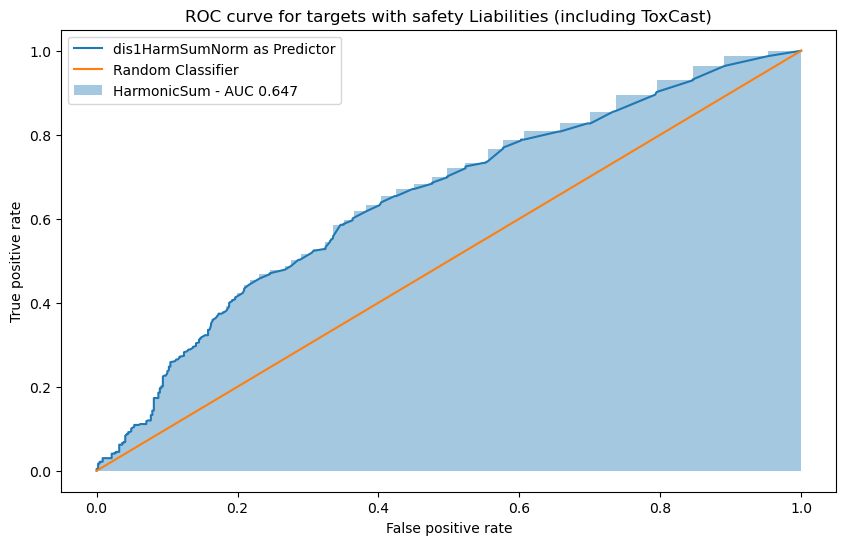

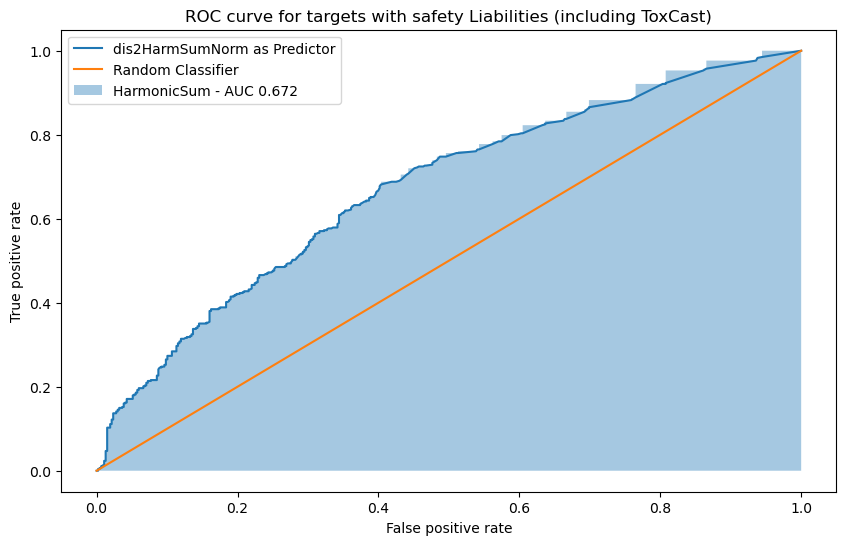

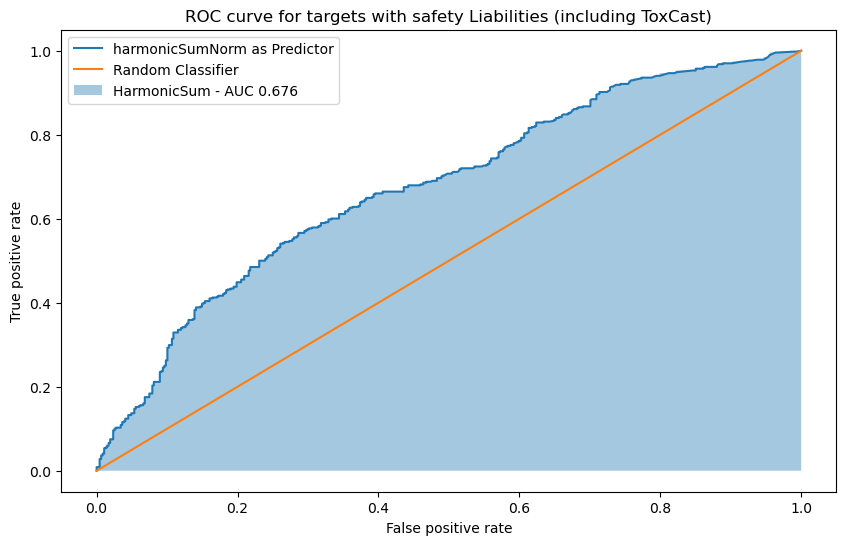

In [25]:
for x in ["dis1HarmSumNorm", "dis2HarmSumNorm", "harmonicSumNorm"]:
    ### harmonicsumnormDiseases1

    targetsToCheckTargetNoToxCast = targetPredictedToxCastNO.union(
        targetWOPredictedToxCastNo
    )
    ## convert to array WO ToxCast
    y_score_targetPredictToxCast = np.array(
        targetsToCheckTargetNoToxCast.select(x).rdd.flatMap(lambda x: x).collect()
    )
    y_targetPredicttoxCast = np.array(
        targetsToCheckTargetNoToxCast.select("y").rdd.flatMap(lambda x: x).collect()
    )

    ### ROc curve
    ## predicted targets
    fpr_noToxCastTarget, tpr_noToxCastTarget, thresholds = roc_curve(
        y_targetPredicttoxCast, y_score_targetPredictToxCast
    )

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(fpr_noToxCastTarget, tpr_noToxCastTarget)
    ax.plot([0, 0.5, 1], [0, 0.5, 1])
    ax.fill_between(fpr_noToxCastTarget, tpr_noToxCastTarget, step="pre", alpha=0.4)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.set_title("ROC curve for targets with safety Liabilities (including ToxCast)")
    ax.legend(
        [
            f"{x} as Predictor",
            "Random Classifier",
            "HarmonicSum - AUC {:.3f}".format(
                roc_auc_score(y_targetPredicttoxCast, y_score_targetPredictToxCast)
            ),
        ]
    )

#### ROC curves about BBW and WD

In [26]:
### Check predictions about BBW and WD

score_lists = ["harmonicSumNorm", "dis1HarmSumNorm", "dis2HarmSumNorm"]
warningTypes = ["allBBW", "allWD"]
keys = ["allBBW", "allWD"]

nBBW = targetPredictedToxCastNO.filter(F.col("allBBW") == 1).count()
nWD = targetPredictedToxCastNO.filter(F.col("allWD") == 1).count()
values = [nBBW, nWD]
combinations = dict(zip(keys, values))

In [27]:
values

[93, 42]

In [28]:
df_transformed.filter(F.col("dis2HarmSumNorm").isNull()).count()

118

allBBW 93 harmonicSumNorm 0.5918222976796831
allBBW 93 dis1HarmSumNorm 0.567992562050287
allBBW 93 dis2HarmSumNorm 0.5919839922386612
allWD 42 harmonicSumNorm 0.5919098822324629
allWD 42 dis1HarmSumNorm 0.5934459805427547
allWD 42 dis2HarmSumNorm 0.58678955453149


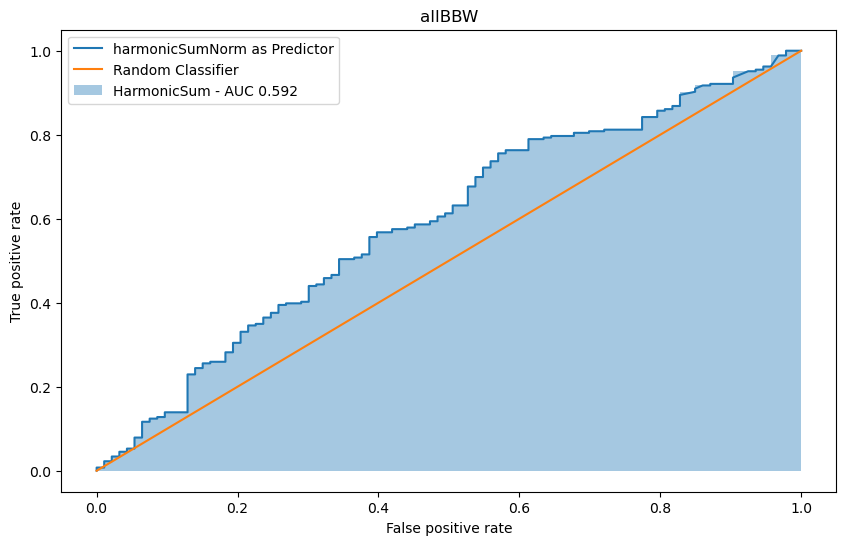

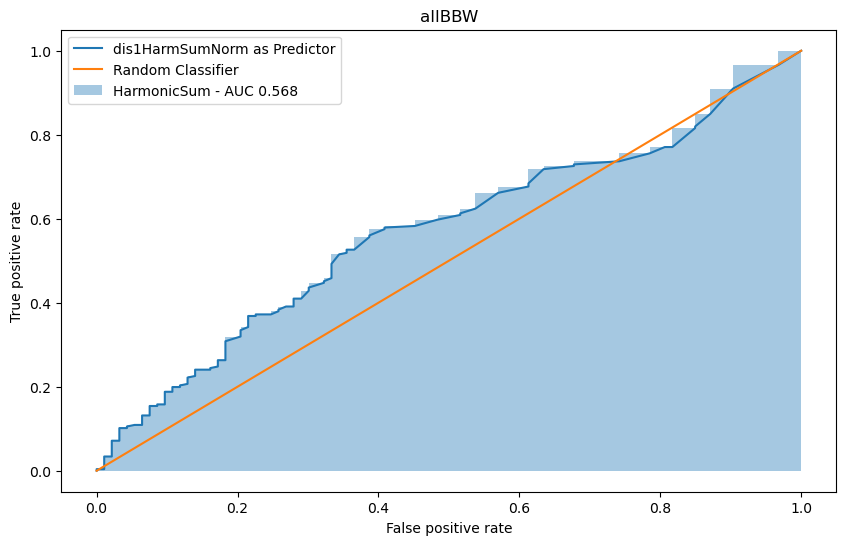

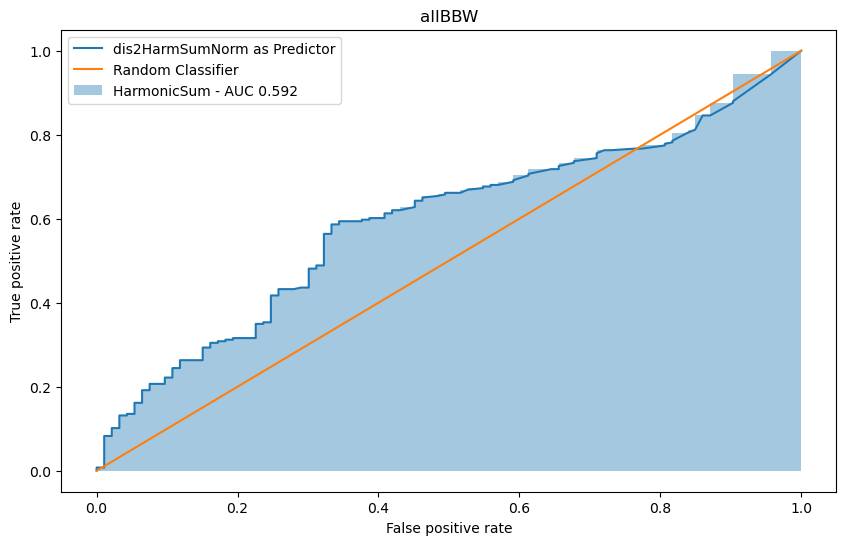

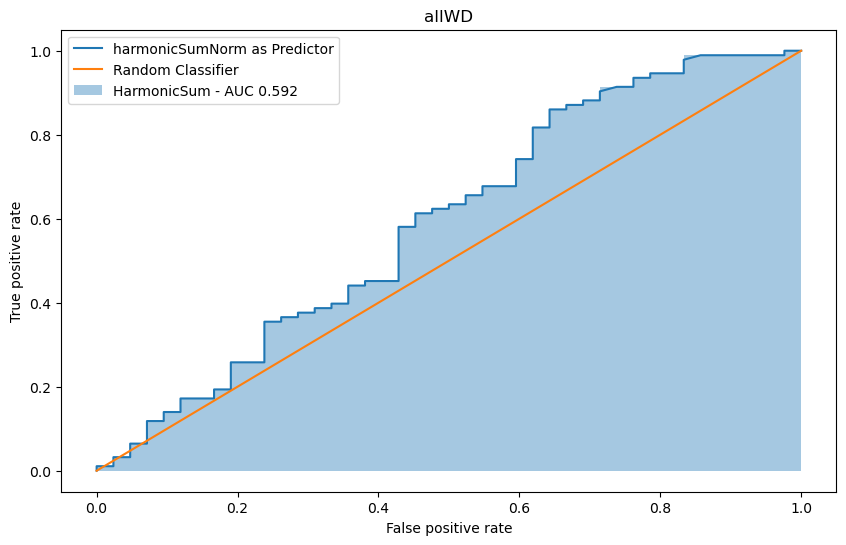

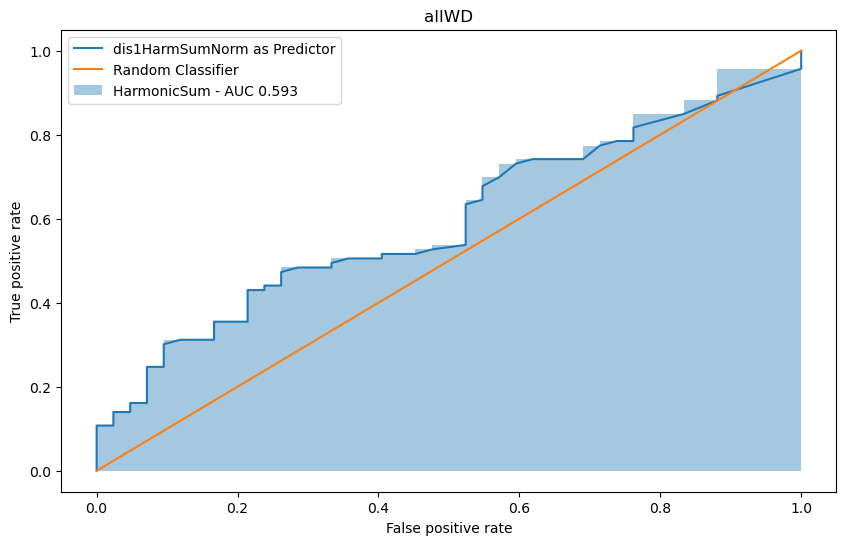

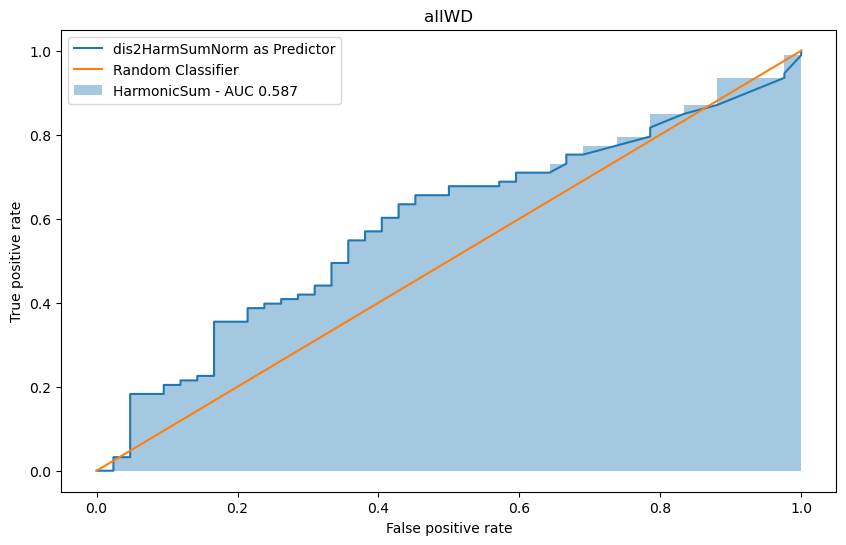

In [29]:
for x, n in combinations.items():
    ### roc curve for Safety Liabilities containing ToxCast:
    ### remove these rows with
    workingDataset = df_transformed.filter(
        (F.col("dis2HarmSumNorm").isNotNull())
        & (F.col("dis1HarmSumNorm").isNotNull())
        & (F.col("harmonicSumNorm").isNotNull())
    )
    targetsWithAnyBBW = workingDataset.filter(F.col(x) == 1).withColumn(
        "y", F.lit(1)
    )  ### there are 260 targets with BBW and mouse phenotypes score
    targetsNoBBW = (
        workingDataset.filter(F.col(x) == 0)
        .sample(False, 0.5, seed=0)
        .limit(n)
        .withColumn("y", F.lit(0))
    )

    targetsToCheck = targetsWithAnyBBW.union(targetsNoBBW)
    ## convert to array WO ToxCast
    for i in score_lists:
        y_score_targetPredict = np.array(
            targetsToCheck.select(i).rdd.flatMap(lambda x: x).collect()
        )
        y_targetPredict = np.array(
            targetsToCheck.select("y").rdd.flatMap(lambda x: x).collect()
        )

        ### ROc curve
        ## predicted targets
        fpr_predictedTargets, tpr_predictedTargets, thresholds = roc_curve(
            y_targetPredict, y_score_targetPredict
        )
        print(x, n, i, roc_auc_score(y_targetPredict, y_score_targetPredict))

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(fpr_predictedTargets, tpr_predictedTargets)
        ax.plot([0, 0.5, 1], [0, 0.5, 1])
        ax.fill_between(
            fpr_predictedTargets, tpr_predictedTargets, step="pre", alpha=0.4
        )
        ax.set_xlabel("False positive rate")
        ax.set_ylabel("True positive rate")
        ax.set_title(x)
        ax.legend(
            [
                i + " as Predictor",
                "Random Classifier",
                "HarmonicSum - AUC {:.3f}".format(
                    roc_auc_score(y_targetPredict, y_score_targetPredict)
                ),
            ]
        )

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LinearSVC

In [31]:
targetsWithAnyBBW = workingDataset.filter(F.col("allWD") == 1).withColumn("y", F.lit(1))
n = workingDataset.filter(F.col("allWD") == 1).withColumn("y", F.lit(1)).count()
### there are 260 targets with BBW and mouse phenotypes score
targetsNoBBW = (
    workingDataset.filter(F.col("allWD") == 0)
    .sample(False, 0.5, seed=0)
    .limit(n)
    .withColumn("y", F.lit(0))
)

targetsToCheck = targetsWithAnyBBW.union(targetsNoBBW)

#### create the dataset with the phenotypes in each row with 0/1
phenotypes = (
    mophe.groupBy("targetFromSourceId")
    .pivot("modelPhenotypeLabel")
    .agg(F.countDistinct(F.col("targetFromSourceId")))
    .na.fill(0)
)

In [32]:
subset = targetsToCheck.select("id", "harmonicSumNorm", "y")

subset2 = subset.join(
    phenotypes.withColumnRenamed("targetFromSourceId", "id"), on="id", how="left"
).drop("id", "harmonicSumNorm")

# Partimos los datos (sin preprocesar)
train, test = subset2.randomSplit([0.7, 0.3], seed=2020)

In [33]:
### try to run with smaller dataset to see if the possible cause is that

In [34]:
# Indexamos la variable a clasificar
indexador = StringIndexer(inputCol="y", outputCol="clase")

# Unimos los atributos con VectorAssembler
assembler = VectorAssembler(inputCols=subset2.columns[1:11], outputCol="atributos")

# Guardamos las etapas del preprocesamiento para qeu se usen en una tubería
etapas = [indexador, assembler]

# Definimos el SVM
svm = LinearSVC(featuresCol="atributos", labelCol="clase", maxIter=10)

# Creamos una tubería, con el preprocesamiento y el SVM
tuberia = Pipeline().setStages(etapas + [svm])


# Construimos el modelo con los datos de entrenamiento
modeloSVM = tuberia.fit(train)

# Hacemos predicciones con el modelo aprendido (preprocesamiento + SVM)
predicciones = modeloSVM.transform(test)

# Ya podemos mostrar la bondad del modelo
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluador = BinaryClassificationEvaluator(labelCol="clase", metricName="areaUnderROC")
evaluador2 = MulticlassClassificationEvaluator(labelCol="clase", metricName="accuracy")

print("ROC AUC:", evaluador.evaluate(predicciones))
print("Accuracy:", evaluador2.evaluate(predicciones))

24/09/30 13:58:22 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 13:58:30 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
24/09/30 13:59:04 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
24/09/30 14:02:22 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 14:05:38 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 14:05:42 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/09/30 14:06:12 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/09/30 14:06:14 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/09/30 14:06:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
24/09/30 14:06:42 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/09/30 14:06:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
24/09/30 14:06:43 WARN DAGScheduler: Broadcasting la

ROC AUC: 0.5


24/09/30 14:25:17 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 14:25:23 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Accuracy: 0.509090909090909


In [35]:
# Ya podemos mostrar la bondad de las predicciones del modelo multiclase
evaluator = MulticlassClassificationEvaluator(labelCol="clase")
print("F1:", evaluator.evaluate(predicciones))
print("Accuracy:", evaluator.evaluate(predicciones, {evaluator.metricName: "accuracy"}))
print(
    "Weighted Precision:",
    evaluator.evaluate(predicciones, {evaluator.metricName: "weightedPrecision"}),
)
print(
    "Weighted Recall:",
    evaluator.evaluate(predicciones, {evaluator.metricName: "weightedRecall"}),
)

24/09/30 14:28:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 14:28:56 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


F1: 0.3434830230010953


24/09/30 14:32:21 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 14:32:26 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Accuracy: 0.509090909090909


24/09/30 14:35:36 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 14:35:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Weighted Precision: 0.25917355371900824


24/09/30 14:38:52 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/09/30 14:38:56 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Weighted Recall: 0.509090909090909
